In [37]:
import numpy as np
import jax.numpy as jnp
import jax
import optax
from functools import partial 

import matplotlib.pyplot as plt

from water_balance_jax import wbm_jax, construct_Kpet_vec

In [38]:
#####################
#### Directories ####
#####################
project_data_path = '/storage/group/pches/default/users/dcl5300/wbm_soilM_crop_uc_lafferty-etal-2024-tbd_DATA'

In [40]:
subset_name = "centralUS"
obs = "VIC"

In [41]:
# Read obs
y = np.load(f'{project_data_path}/WBM/precalibration/{subset_name}/{obs}/{obs}_validation.npy')

In [42]:
# Read and extract inputs
npz = np.load(f"{project_data_path}/WBM/precalibration/{subset_name}/{obs}/inputs.npz")

tas = npz['tas']
prcp = npz['prcp']

lai = npz['lai']

awCap = npz['awCap']
wiltingp = npz['wiltingp']

corn = npz['corn']
cotton = npz['cotton']
rice = npz['rice']
sorghum = npz['sorghum']
soybeans = npz['soybeans']
durum_wheat = npz['durum_wheat']
spring_wheat = npz['spring_wheat']
winter_wheat = npz['winter_wheat']

wheat = durum_wheat + spring_wheat + winter_wheat

cropland_other = npz['cropland_other']
water = npz['water']
evergreen_needleleaf = npz['evergreen_needleleaf']
evergreen_broadleaf = npz['evergreen_broadleaf']
deciduous_needleleaf = npz['deciduous_needleleaf']
deciduous_broadleaf = npz['deciduous_broadleaf']
mixed_forest = npz['mixed_forest']
woodland = npz['woodland']
wooded_grassland = npz['wooded_grassland']
closed_shurbland = npz['closed_shurbland']
open_shrubland = npz['open_shrubland']
grassland = npz['grassland']
barren = npz['barren']
urban = npz['urban']

all_other = cropland_other + water + evergreen_needleleaf + evergreen_broadleaf + deciduous_needleleaf + deciduous_broadleaf + mixed_forest + woodland + wooded_grassland + closed_shurbland + open_shrubland + grassland + barren + urban

clayfrac = npz['clayfrac']
sandfrac = npz['sandfrac']
siltfrac = npz['siltfrac']

elev_std = npz['elev_std']

lats = npz['lats']
lons = npz['lons']

Ws_init = npz['soilMoist_init']

In [43]:
# Prepare inputs for vmap: spatial dimensions need to be collapsed and first; NaN gridpoints removed
nx = tas.shape[0]
ny = tas.shape[1]
nt = tas.shape[2]

assert nt % 365 == 0
nyrs = int(nt / 365)

# # NaNs based on lai, prcp, tas
# nan_inds_lai = jnp.isnan(lai.reshape(nx * ny, 365)).any(axis=1)
# nan_inds_tas = jnp.isnan(tas.reshape(nx * ny, nt)).any(axis=1)
# nan_inds_prcp = jnp.isnan(prcp.reshape(nx * ny, nt)).any(axis=1)
# nan_inds = nan_inds_lai * nan_inds_prcp * nan_inds_tas

## Obs
ys = y.reshape(nx * ny, nt)
nan_inds_obs = jnp.isnan(ys).any(axis=1)

## Forcing: all days
tas_in = tas.reshape(nx * ny, nt)
prcp_in = prcp.reshape(nx * ny, nt)

x_forcing_nt = jnp.stack([tas_in, prcp_in], axis=1)
nan_inds_forcing_nt = jnp.isnan(x_forcing_nt).any(axis=(1,2))

## Forcing: yearly
lai_in = lai.reshape(nx * ny, 365)
x_forcing_nyrs = lai_in
nan_inds_forcing_nyrs = jnp.isnan(x_forcing_nyrs).any(axis=1)

## Maps
awCap_in = awCap.reshape(nx * ny)
wiltingp_in = wiltingp.reshape(nx * ny)

Ws_init_in = Ws_init.reshape(nx * ny)
Wi_init_in = np.zeros(nx * ny)
Sp_init_in = np.zeros(nx * ny)

clayfrac_in = clayfrac.reshape(nx * ny)
sandfrac_in = sandfrac.reshape(nx * ny)
siltfrac_in = siltfrac.reshape(nx * ny)

lats_in = np.tile(lats, nx)
elev_std_in = elev_std.reshape(nx * ny)

corn_in = corn.reshape(nx * ny)
cotton_in = cotton.reshape(nx * ny)
rice_in = rice.reshape(nx * ny)
sorghum_in = sorghum.reshape(nx * ny)
soybeans_in = soybeans.reshape(nx * ny)
wheat_in = wheat.reshape(nx * ny)

all_other_in = all_other.reshape(nx * ny)

x_maps = jnp.stack([awCap_in, wiltingp_in, 
                    Ws_init_in, Wi_init_in, Sp_init_in, 
                    clayfrac_in, sandfrac_in, siltfrac_in, 
                    lats_in, elev_std_in,
                    corn_in, cotton_in, rice_in, sorghum_in, soybeans_in, wheat_in],
                   axis=1)
nan_inds_maps = jnp.isnan(x_maps).any(axis=1)

# All NaNs
nan_inds = nan_inds_obs + nan_inds_forcing_nt + nan_inds_forcing_nyrs + nan_inds_maps
ys = ys[~nan_inds]
x_forcing_nt = x_forcing_nt[~nan_inds]
x_forcing_nyrs = x_forcing_nyrs[~nan_inds]
x_maps = x_maps[~nan_inds]

###### Params
awCap_scalar = jnp.log(1.)
wiltingp_scalar = jnp.log(1.)

alpha_claycoef = jnp.log(0.5)
alpha_sandcoef = jnp.log(0.5)
alpha_siltcoef = jnp.log(0.5)

betaHBV_claycoef = jnp.log(0.5)
betaHBV_sandcoef = jnp.log(0.5)
betaHBV_siltcoef = jnp.log(0.5)
betaHBV_elevcoef = jnp.log(0.5)

GS_start_corn = jnp.log(91) # April 1st
GS_length_corn = jnp.log(274 - 91) # April 1st -> October 1st
L_ini_corn = jnp.log(0.17)
L_dev_corn = jnp.log(0.28)
L_mid_corn = jnp.log(0.33)
Kc_ini_corn = jnp.log(0.3)
Kc_mid_corn = jnp.log(1.2)
Kc_end_corn = jnp.log(0.4)
K_min_corn = jnp.log(0.3)
K_max_corn = jnp.log(1.2)

GS_start_cotton = jnp.log(91) # April 1st
GS_length_cotton = jnp.log(274 - 91) # April 1st -> October 1st
L_ini_cotton = jnp.log(0.17)
L_dev_cotton = jnp.log(0.33)
L_mid_cotton = jnp.log(0.25)
Kc_ini_cotton = jnp.log(0.35)
Kc_mid_cotton = jnp.log(1.18)
Kc_end_cotton = jnp.log(0.6)
K_min_cotton = jnp.log(0.35)
K_max_cotton = jnp.log(1.18)

# Rice growing season: https://www.ers.usda.gov/topics/crops/rice/rice-sector-at-a-glance/
GS_start_rice = jnp.log(91) # April 1st
GS_length_rice = jnp.log(244 - 91) # April 1st -> September 1st
L_ini_rice = jnp.log(0.17)
L_dev_rice = jnp.log(0.28)
L_mid_rice = jnp.log(0.44)
Kc_ini_rice = jnp.log(1.05)
Kc_mid_rice = jnp.log(1.2)
Kc_end_rice = jnp.log(0.75)
K_min_rice = jnp.log(0.75)
K_max_rice = jnp.log(1.2)

GS_start_sorghum = jnp.log(91) # April 1st
GS_length_sorghum = jnp.log(274 - 91) # April 1st -> October 1st
L_ini_sorghum = jnp.log(0.15)
L_dev_sorghum = jnp.log(0.28)
L_mid_sorghum = jnp.log(0.33)
Kc_ini_sorghum = jnp.log(0.3)
Kc_mid_sorghum = jnp.log(1.1)
Kc_end_sorghum = jnp.log(0.55)
K_min_sorghum = jnp.log(0.3)
K_max_sorghum = jnp.log(1.1)

GS_start_soybeans = jnp.log(91) # April 1st
GS_length_soybeans = jnp.log(274 - 91) # April 1st -> October 1st 
L_ini_soybeans = jnp.log(0.15)
L_dev_soybeans = jnp.log(0.2)
L_mid_soybeans = jnp.log(0.45)
Kc_ini_soybeans = jnp.log(0.4)
Kc_mid_soybeans = jnp.log(1.15)
Kc_end_soybeans = jnp.log(0.5)
K_min_soybeans = jnp.log(0.4)
K_max_soybeans = jnp.log(1.15)

# Assume spring wheat
GS_start_wheat = jnp.log(91) # April 1st
GS_length_wheat = jnp.log(244 - 91) # April 1st -> September 1st
L_ini_wheat = jnp.log(0.15)
L_dev_wheat = jnp.log(0.25)
L_mid_wheat = jnp.log(0.4)
Kc_ini_wheat = jnp.log(0.4)
Kc_mid_wheat = jnp.log(1.15)
Kc_end_wheat = jnp.log(0.3)
K_min_wheat = jnp.log(0.3)
K_max_wheat = jnp.log(1.15)

params_in = jnp.array([awCap_scalar, wiltingp_scalar, \
                       alpha_claycoef, alpha_sandcoef, alpha_siltcoef, \
                       betaHBV_claycoef, betaHBV_sandcoef, betaHBV_siltcoef, betaHBV_elevcoef, \
                       GS_start_corn, GS_length_corn, L_ini_corn, L_dev_corn, L_mid_corn, Kc_ini_corn, Kc_mid_corn, Kc_end_corn, K_min_corn, K_max_corn, \
                       GS_start_cotton, GS_length_cotton, L_ini_cotton, L_dev_cotton, L_mid_cotton, Kc_ini_cotton, Kc_mid_cotton, Kc_end_cotton, K_min_cotton, K_max_cotton, \
                       GS_start_rice, GS_length_rice, L_ini_rice, L_dev_rice, L_mid_rice, Kc_ini_rice, Kc_mid_rice, Kc_end_rice, K_min_rice, K_max_rice,  \
                       GS_start_sorghum, GS_length_sorghum, L_ini_sorghum, L_dev_sorghum, L_mid_sorghum, Kc_ini_sorghum, Kc_mid_sorghum, Kc_end_sorghum, K_min_sorghum, K_max_sorghum, \
                       GS_start_soybeans, GS_length_soybeans, L_ini_soybeans, L_dev_soybeans, L_mid_soybeans, Kc_ini_soybeans, Kc_mid_soybeans, Kc_end_soybeans, K_min_soybeans, K_max_soybeans, \
                       GS_start_wheat, GS_length_wheat, L_ini_wheat, L_dev_wheat, L_mid_wheat, Kc_ini_wheat, Kc_mid_wheat, Kc_end_wheat, K_min_wheat, K_max_wheat])

In [44]:
# Constants
Ts = -1. # Snowfall threshold
Tm = 1.  # Snowmelt threshold

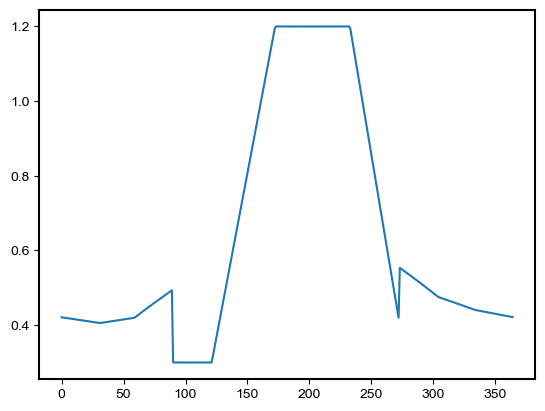

In [63]:
ixy = 100

Kpet = construct_Kpet_vec(jnp.exp(GS_start_corn),
                            jnp.exp(GS_length_corn),
                            jnp.exp(L_ini_corn),
                            jnp.exp(L_dev_corn),
                            jnp.exp(L_mid_corn),
                            1. - (jnp.exp(L_ini_corn) + jnp.exp(L_dev_corn) + jnp.exp(L_mid_corn)),
                            jnp.exp(Kc_ini_corn),
                            jnp.exp(Kc_mid_corn),
                            jnp.exp(Kc_end_corn),
                            jnp.exp(K_min_corn),
                            jnp.exp(K_max_corn), lai_in[ixy,:])

plt.plot(Kpet)

In [64]:
# test
out = wbm_jax(
    tas=tas_in[ixy, :],
    prcp=prcp_in[ixy, :],
    Kpet=Kpet,
    Ws_init=Ws_init_in[ixy],
    Wi_init=Wi_init_in[ixy],
    Sp_init=Sp_init_in[ixy],
    lai=lai_in[ixy, :],
    phi=lats_in[ixy],
    params=(Ts, Tm, wiltingp_in[ixy], awCap_in[ixy], 5., 3.),
)

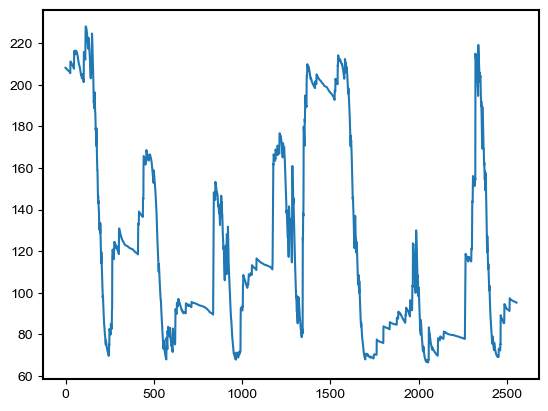

In [65]:
plt.plot(out)

In [66]:
# vmap function (vectorizing map for running WBM over space)
# in_axes define axis that we iterature over for inputs of wbm_jax (i.e. tas, prcp, etc -- all inputs with spatial dimension)
# out_axes define where mapped axis should appear in output
wbm_jax_vmap = jax.jit(jax.vmap(fun=wbm_jax,
                                in_axes=(0, 0, 0, 0, 0, 0, 0, 0, None),
                                out_axes=0))

In [67]:
def loss_fn(theta,
            x_forcing_nt,
            x_forcing_nyrs,
            x_maps,
            ys
           ):

    # Read inputs
    tas, prcp = x_forcing_nt
    lai = x_forcing_nyrs
    awCap, wiltingp, \
    Ws_init, Wi_init, Sp_init, \
    clayfrac, sandfrac, siltfrac, \
    lats, elev_std, \
    corn, cotton, rice, sorghum, soybeans, wheat \
    = x_maps
    
    
    # Define all params
    awCap_scalar, wiltingp_scalar, \
    alpha_claycoef, alpha_sandcoef, alpha_siltcoef, \
    betaHBV_claycoef, betaHBV_sandcoef, betaHBV_siltcoef, betaHBV_elevcoef, \
    GS_start_corn, GS_length_corn, L_ini_corn, L_dev_corn, L_mid_corn, Kc_ini_corn, Kc_mid_corn, Kc_end_corn, K_min_corn, K_max_corn, \
    GS_start_cotton, GS_length_cotton, L_ini_cotton, L_dev_cotton, L_mid_cotton, Kc_ini_cotton, Kc_mid_cotton, Kc_end_cotton, K_min_cotton, K_max_cotton, \
    GS_start_rice, GS_length_rice, L_ini_rice, L_dev_rice, L_mid_rice, Kc_ini_rice, Kc_mid_rice, Kc_end_rice, K_min_rice, K_max_rice,  \
    GS_start_sorghum, GS_length_sorghum, L_ini_sorghum, L_dev_sorghum, L_mid_sorghum, Kc_ini_sorghum, Kc_mid_sorghum, Kc_end_sorghum, K_min_sorghum, K_max_sorghum, \
    GS_start_soybeans, GS_length_soybeans, L_ini_soybeans, L_dev_soybeans, L_mid_soybeans, Kc_ini_soybeans, Kc_mid_soybeans, Kc_end_soybeans, K_min_soybeans, K_max_soybeans, \
    GS_start_wheat, GS_length_wheat, L_ini_wheat, L_dev_wheat, L_mid_wheat, Kc_ini_wheat, Kc_mid_wheat, Kc_end_wheat, K_min_wheat, K_max_wheat \
    = jnp.exp(theta)

    # Construct Kpet as weighted average
    Kpet_corn = construct_Kpet_vec(GS_start_corn, GS_length_corn, L_ini_corn, L_dev_corn, L_mid_corn, 1. - (L_ini_corn + L_dev_corn + L_mid_corn), Kc_ini_corn, Kc_mid_corn, Kc_end_corn, K_min_corn, K_max_corn, lai)
    Kpet_cotton = construct_Kpet_vec(GS_start_cotton, GS_length_cotton, L_ini_cotton, L_dev_cotton, L_mid_cotton, 1. - (L_ini_cotton + L_dev_cotton + L_mid_cotton), Kc_ini_cotton, Kc_mid_cotton, Kc_end_cotton, K_min_cotton, K_max_cotton, lai)
    Kpet_rice = construct_Kpet_vec(GS_start_rice, GS_length_rice, L_ini_rice, L_dev_rice, L_mid_rice, 1. - (L_ini_rice + L_dev_rice + L_mid_rice), Kc_ini_rice, Kc_mid_rice, Kc_end_rice, K_min_rice, K_max_rice, lai)
    Kpet_sorghum = construct_Kpet_vec(GS_start_sorghum, GS_length_sorghum, L_ini_sorghum, L_dev_sorghum, L_mid_sorghum, 1. - (L_ini_sorghum + L_dev_sorghum + L_mid_sorghum), Kc_ini_sorghum, Kc_mid_sorghum, Kc_end_sorghum, K_min_sorghum, K_max_sorghum, lai)
    Kpet_soybeans = construct_Kpet_vec(GS_start_soybeans, GS_length_soybeans, L_ini_soybeans, L_dev_soybeans, L_mid_soybeans, 1. - (L_ini_soybeans + L_dev_soybeans + L_mid_soybeans), Kc_ini_soybeans, Kc_mid_soybeans, Kc_end_soybeans, K_min_soybeans, K_max_soybeans, lai)
    Kpet_wheat = construct_Kpet_vec(GS_start_wheat, GS_length_wheat, L_ini_wheat, L_dev_wheat, L_mid_wheat, 1. - (L_ini_wheat + L_dev_wheat + L_mid_wheat), Kc_ini_wheat, Kc_mid_wheat, Kc_end_wheat, K_min_wheat, K_max_wheat, lai)

    other = 1. - (corn + cotton + rice + sorghum + soybeans + wheat)
    weights = jnp.array([corn, cotton, rice, sorghum, soybeans, wheat, other])
    Kpets = jnp.array([Kpet_corn, Kpet_cotton, Kpet_rice, Kpet_sorghum, Kpet_soybeans, Kpet_wheat, jnp.ones(365)])
    Kpet = jnp.average(Kpets, weights = weights, axis=0)
    
    # params that WBM sees
    awCap_scaled = awCap * awCap_scalar
    wiltingp_scaled = wiltingp * wiltingp_scalar
    alpha = 1.0 + (alpha_claycoef * clayfrac) + (alpha_sandcoef * sandfrac) + (alpha_siltcoef * siltfrac)
    betaHBV = 1.0 + (betaHBV_claycoef * clayfrac) + (betaHBV_sandcoef * sandfrac) + (betaHBV_siltcoef * siltfrac) + (betaHBV_elevcoef * elev_std)
    
    params = (Ts, Tm, wiltingp_scaled, awCap_scaled, alpha, betaHBV)
    
    # Make prediction
    prediction = wbm_jax(
        tas,
        prcp, 
        Kpet,
        Ws_init,
        Wi_init,
        Sp_init,
        lai,
        lats,
        params
    )
    # Return RMSE 
    # plt.plot(prediction)
    # plt.plot(ys)
    return jnp.sqrt(jnp.mean((prediction-ys)**2))

In [70]:
# test
ixy = 100

loss_fn(
    params_in,
    x_forcing_nt[ixy],
    x_forcing_nyrs[ixy],
    x_maps[ixy],
    ys[ixy]
)

Array(62.556465, dtype=float32)

In [71]:
# vmapped gradient of loss function
loss_grad = jax.jit(jax.vmap(jax.grad(loss_fn), in_axes=(None, 0, 0, 0, 0), out_axes=0))
loss_value_and_grad = jax.jit(jax.vmap(jax.value_and_grad(loss_fn), in_axes=(None, 0, 0, 0, 0), out_axes=0))

In [75]:
%%time

# Define mini-batch hyper-parameters
N = ys.shape[0]
batch_size = 2**7
n_minibatches = N // batch_size

# Initial parameters
theta = params_in

# Optimizer
adam = optax.adam(learning_rate=1e-2)
opt_fn = adam.update
opt_state = adam.init(theta)

# adagrad = optax.adagrad(learning_rate = 0.01)
# opt_fn = adagrad.update
# opt_state = adagrad.init(theta)

# SGD optimizers
# learning_rate = 1e-5
# opt_state = None
# def sgd(gradients, state):
#     return -learning_rate * gradients, state
# opt_fn = sgd

# Epochs
n_epochs = 20

# Loss
loss_out = np.empty(n_epochs)

for epoch in range(n_epochs):
    # Shuffle indices
    shuffled_inds = np.random.permutation(N)
    
    # Generate a mini-batch
    minibatch_inds = [shuffled_inds[(i*batch_size):((i + 1)*batch_size)] for i in range(n_minibatches + 1)]

    for idx, inds in enumerate(minibatch_inds):
        minibatch_loss = np.empty(len(minibatch_inds))
        # Calculate gradient of loss function, update parameters
        loss, grads = loss_value_and_grad(theta,
                                          x_forcing_nt[inds],
                                          x_forcing_nyrs[inds],
                                          x_maps[inds],
                                          ys[inds])
        updates, opt_state = opt_fn(jnp.mean(grads, axis=0), opt_state)
        theta = optax.apply_updates(theta, updates)
        minibatch_loss[idx] = jnp.mean(loss)

    # Store loss
    loss_out[epoch] = jnp.nanmean(minibatch_loss)
    if epoch % 5 == 0:
        print(f"Epoch {str(epoch)}, loss: {loss_out[epoch]:.2f}")
    if jnp.sum(jnp.isnan(loss)) or jnp.sum(jnp.isnan(grads)):
            break

Epoch 0, loss: 19.50
Epoch 5, loss: 17.07
Epoch 10, loss: 16.84
Epoch 15, loss: 16.81
CPU times: user 8min 34s, sys: 39.1 s, total: 9min 13s
Wall time: 9min 16s


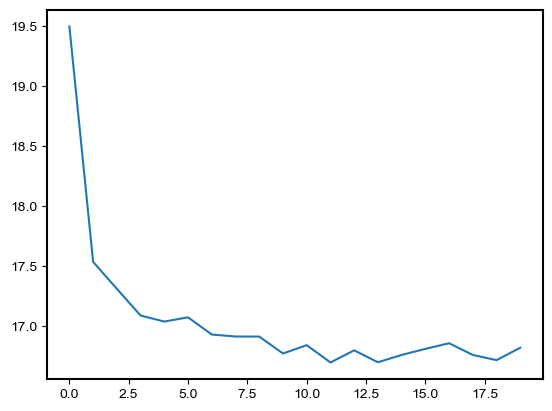

In [78]:
plt.plot(loss_out)

In [79]:
jnp.exp(theta)

Array([9.09774959e-01, 1.90055490e+00, 1.02394465e-02, 1.00707682e-02,
       1.10695399e-02, 1.35107780e+00, 2.83975840e+00, 6.78541899e-01,
       8.24121572e-03, 1.02290680e+02, 3.14022156e+02, 1.50152981e-01,
       2.82179505e-01, 5.50979853e-01, 3.33989024e-01, 1.80124760e+00,
       6.10677958e-01, 1.98858988e+00, 3.71787131e-01, 1.50804611e+02,
       2.23116241e+02, 2.83003002e-01, 8.78261805e-01, 1.51704177e-01,
       2.61628516e-02, 5.44940591e-01, 4.23035085e-01, 1.25494108e-01,
       1.05405331e-01, 5.67058334e+01, 5.01753082e+01, 2.72473633e-01,
       2.65088379e-01, 1.97873533e-01, 8.44769001e+00, 1.40141308e+00,
       2.31793404e-01, 9.86979187e-01, 1.64871439e-01, 8.78165283e+01,
       1.33915329e+02, 2.83882046e+00, 3.03060561e-01, 1.72479212e-01,
       6.95248484e-04, 5.43178499e-01, 2.32040614e-01, 3.99793265e-03,
       1.62861738e-02, 1.03802734e+02, 1.82779510e+02, 2.25491941e-01,
       2.32626423e-01, 4.64973509e-01, 1.72029495e+00, 2.62909102e+00,
      

In [16]:
# # SMAP
# theta_best = jnp.array([8.9403856e-01, 1.2090306e+00, 7.3919883e+00, 1.9614664e+00,
#        1.1749062e-01, 9.0727499e-03, 1.3993982e-03, 1.6604717e-01,
#        1.0718897e-03, 1.1744333e+02, 2.3608478e+02, 1.5193775e-01,
#        2.4811780e-01, 6.1527133e-01, 7.8409779e-01, 1.2505524e+00,
#        5.5005902e-01, 3.0709976e-01, 4.3270440e+00, 1.6301947e+02,
#        3.1507974e+02, 2.8909954e-01, 2.7157897e-01, 2.3978040e-01,
#        8.5391656e-02, 2.1546469e+00, 5.9780562e-01, 2.3592494e+00,
#        2.8582275e-01, 5.5110710e+01, 7.0740746e+01, 1.8646681e-01,
#        1.6630177e-01, 2.4578252e-01, 4.0569468e+00, 9.9713296e-01,
#        2.8053612e-01, 1.2319384e+00, 2.1649329e-01, 1.8669823e+01,
#        1.3861009e+02, 2.3399444e-02, 4.4324577e-02, 9.6171468e-01,
#        4.9724461e+01, 5.8776746e+00, 7.0852125e-01, 7.7651799e-01,
#        5.0479751e+00, 1.4747961e+02, 2.7958264e+02, 1.4980780e-01,
#        4.3016854e-01, 5.8167714e-01, 2.5418505e-01, 1.6534770e+00,
#        6.3492835e-01, 8.9343613e-01, 1.4926931e-01, 4.0624168e+01,
#        1.0198341e+02, 8.1905365e-02, 2.6759255e-01, 7.0615453e-01,
#        1.8233963e+00, 1.9868934e+00, 1.8245393e-01, 1.4239122e-01,
#        3.6198720e-02])

# theta = jnp.log(theta_best)

In [80]:
# Get all (with NaNs)
## Obs
ys = y.reshape(nx * ny, nt)

## Forcing: all days
tas_in = tas.reshape(nx * ny, nt)
prcp_in = prcp.reshape(nx * ny, nt)

x_forcing_nt = jnp.stack([tas_in, prcp_in], axis=1)

## Forcing: yearly
lai_in = lai.reshape(nx * ny, 365)
x_forcing_nyrs = lai_in

## Maps
awCap_in = awCap.reshape(nx * ny)
wiltingp_in = wiltingp.reshape(nx * ny)

Ws_init_in = Ws_init.reshape(nx * ny)
Wi_init_in = np.zeros(nx * ny)
Sp_init_in = np.zeros(nx * ny)

clayfrac_in = clayfrac.reshape(nx * ny)
sandfrac_in = sandfrac.reshape(nx * ny)
siltfrac_in = siltfrac.reshape(nx * ny)

lats_in = np.tile(lats, nx)
elev_std_in = elev_std.reshape(nx * ny)

corn_in = corn.reshape(nx * ny)
cotton_in = cotton.reshape(nx * ny)
rice_in = rice.reshape(nx * ny)
sorghum_in = sorghum.reshape(nx * ny)
soybeans_in = soybeans.reshape(nx * ny)
wheat_in = wheat.reshape(nx * ny)

all_other_in = all_other.reshape(nx * ny)

x_maps = jnp.stack([awCap_in, wiltingp_in, 
                    Ws_init_in, Wi_init_in, Sp_init_in, 
                    clayfrac_in, sandfrac_in, siltfrac_in, 
                    lats_in, elev_std_in,
                    corn_in, cotton_in, rice_in, sorghum_in, soybeans_in, wheat_in],
                   axis=1)

In [81]:
def predict_spatial(theta,
            x_forcing_nt,
            x_forcing_nyrs,
            x_maps
           ):

    # Read inputs
    tas, prcp = x_forcing_nt
    lai = x_forcing_nyrs
    awCap, wiltingp, \
    Ws_init, Wi_init, Sp_init, \
    clayfrac, sandfrac, siltfrac, \
    lats, elev_std, \
    corn, cotton, rice, sorghum, soybeans, wheat \
    = x_maps
    
    
    # Define all params
    awCap_scalar, wiltingp_scalar, \
    alpha_claycoef, alpha_sandcoef, alpha_siltcoef, \
    betaHBV_claycoef, betaHBV_sandcoef, betaHBV_siltcoef, betaHBV_elevcoef, \
    GS_start_corn, GS_length_corn, L_ini_corn, L_dev_corn, L_mid_corn, Kc_ini_corn, Kc_mid_corn, Kc_end_corn, K_min_corn, K_max_corn, \
    GS_start_cotton, GS_length_cotton, L_ini_cotton, L_dev_cotton, L_mid_cotton, Kc_ini_cotton, Kc_mid_cotton, Kc_end_cotton, K_min_cotton, K_max_cotton, \
    GS_start_rice, GS_length_rice, L_ini_rice, L_dev_rice, L_mid_rice, Kc_ini_rice, Kc_mid_rice, Kc_end_rice, K_min_rice, K_max_rice,  \
    GS_start_sorghum, GS_length_sorghum, L_ini_sorghum, L_dev_sorghum, L_mid_sorghum, Kc_ini_sorghum, Kc_mid_sorghum, Kc_end_sorghum, K_min_sorghum, K_max_sorghum, \
    GS_start_soybeans, GS_length_soybeans, L_ini_soybeans, L_dev_soybeans, L_mid_soybeans, Kc_ini_soybeans, Kc_mid_soybeans, Kc_end_soybeans, K_min_soybeans, K_max_soybeans, \
    GS_start_wheat, GS_length_wheat, L_ini_wheat, L_dev_wheat, L_mid_wheat, Kc_ini_wheat, Kc_mid_wheat, Kc_end_wheat, K_min_wheat, K_max_wheat \
    = jnp.exp(theta)

    # Construct Kpet as weighted average
    Kpet_corn = construct_Kpet_vec(GS_start_corn, GS_length_corn, L_ini_corn, L_dev_corn, L_mid_corn, 1. - (L_ini_corn + L_dev_corn + L_mid_corn), Kc_ini_corn, Kc_mid_corn, Kc_end_corn, K_min_corn, K_max_corn, lai)
    Kpet_cotton = construct_Kpet_vec(GS_start_cotton, GS_length_cotton, L_ini_cotton, L_dev_cotton, L_mid_cotton, 1. - (L_ini_cotton + L_dev_cotton + L_mid_cotton), Kc_ini_cotton, Kc_mid_cotton, Kc_end_cotton, K_min_cotton, K_max_cotton, lai)
    Kpet_rice = construct_Kpet_vec(GS_start_rice, GS_length_rice, L_ini_rice, L_dev_rice, L_mid_rice, 1. - (L_ini_rice + L_dev_rice + L_mid_rice), Kc_ini_rice, Kc_mid_rice, Kc_end_rice, K_min_rice, K_max_rice, lai)
    Kpet_sorghum = construct_Kpet_vec(GS_start_sorghum, GS_length_sorghum, L_ini_sorghum, L_dev_sorghum, L_mid_sorghum, 1. - (L_ini_sorghum + L_dev_sorghum + L_mid_sorghum), Kc_ini_sorghum, Kc_mid_sorghum, Kc_end_sorghum, K_min_sorghum, K_max_sorghum, lai)
    Kpet_soybeans = construct_Kpet_vec(GS_start_soybeans, GS_length_soybeans, L_ini_soybeans, L_dev_soybeans, L_mid_soybeans, 1. - (L_ini_soybeans + L_dev_soybeans + L_mid_soybeans), Kc_ini_soybeans, Kc_mid_soybeans, Kc_end_soybeans, K_min_soybeans, K_max_soybeans, lai)
    Kpet_wheat = construct_Kpet_vec(GS_start_wheat, GS_length_wheat, L_ini_wheat, L_dev_wheat, L_mid_wheat, 1. - (L_ini_wheat + L_dev_wheat + L_mid_wheat), Kc_ini_wheat, Kc_mid_wheat, Kc_end_wheat, K_min_wheat, K_max_wheat, lai)

    other = 1. - (corn + cotton + rice + sorghum + soybeans + wheat)
    weights = jnp.array([corn, cotton, rice, sorghum, soybeans, wheat, other])
    Kpets = jnp.array([Kpet_corn, Kpet_cotton, Kpet_rice, Kpet_sorghum, Kpet_soybeans, Kpet_wheat, jnp.ones(365)])
    Kpet = jnp.average(Kpets, weights = weights, axis=0)
    
    # params that WBM sees
    awCap_scaled = awCap * awCap_scalar
    wiltingp_scaled = wiltingp * wiltingp_scalar
    alpha = 1.0 + (alpha_claycoef * clayfrac) + (alpha_sandcoef * sandfrac) + (alpha_siltcoef * siltfrac)
    betaHBV = 1.0 + (betaHBV_claycoef * clayfrac) + (betaHBV_sandcoef * sandfrac) + (betaHBV_siltcoef * siltfrac) + (betaHBV_elevcoef * elev_std)
    
    params = (Ts, Tm, wiltingp_scaled, awCap_scaled, alpha, betaHBV)
    
    # Make prediction
    return wbm_jax(
        tas,
        prcp, 
        Kpet,
        Ws_init,
        Wi_init,
        Sp_init,
        lai,
        lats,
        params
    )

In [82]:
# vmap spatial prediction
spatial_vmap = jax.jit(jax.vmap(predict_spatial, in_axes=(None, 0, 0, 0), out_axes=0))

In [83]:
%%time
out = spatial_vmap(
    theta,
    x_forcing_nt,
    x_forcing_nyrs,
    x_maps
)

CPU times: user 10.5 s, sys: 704 ms, total: 11.2 s
Wall time: 11.4 s


In [84]:
import xarray as xr
import pandas as pd

In [85]:
# Construct xr 
ds_sim = xr.Dataset(
    data_vars=dict(soilMoist=(["time", "lat", "lon"], np.transpose(out.reshape(nx, ny, nt), (2,1,0)))),
    coords=dict(
        lon=np.arange(-103.938, -80.5629999, 0.125), # CENTRAL US ONLY!
        lat=np.arange(36.063, 49.313001, 0.125), # CENTRAL US ONLY!
        time=pd.date_range(start='01/01/2016', end='12/31/2022', periods=nt)))

In [86]:
ds_obs = xr.Dataset(
    data_vars=dict(soilMoist=(["time", "lat", "lon"], np.transpose(y, (2,1,0)))),
    coords=dict(
        lon=np.arange(-103.938, -80.5629999, 0.125), # CENTRAL US ONLY!
        lat=np.arange(36.063, 49.313001, 0.125), # CENTRAL US ONLY!
        time=pd.date_range(start='01/01/2016', end='12/31/2022', periods=nt)))

In [87]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import regionmask

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.size"] = 10
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["axes.linewidth"] = 1.50

RMSE: 17.282899856567383


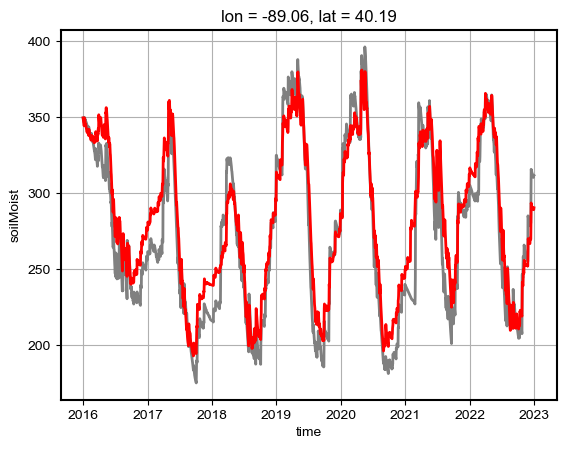

In [91]:
lat1, lon1 = 40.2,-89.1
# lat1, lon1 = 41.93255367319802, -95.74224906197333

fig, ax = plt.subplots()

ds_sim.soilMoist.sel(lat=lat1, lon=lon1, method='nearest').plot(lw=2, color='gray')
ds_obs.soilMoist.sel(lat=lat1, lon=lon1, method='nearest').plot(lw=2, color='red')

diff = ds_sim.soilMoist.sel(lat=lat1, lon=lon1, method='nearest') - ds_obs.soilMoist.sel(lat=lat1, lon=lon1, method='nearest')
rmse = np.sqrt((diff**2).mean(dim='time')).values

print(f"RMSE: {rmse}")

ax.grid()

plt.show()

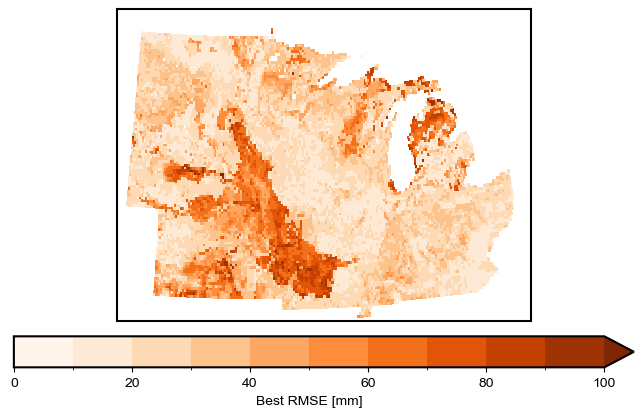

In [90]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5),
                        subplot_kw=dict(projection=ccrs.LambertConformal()))

ds_rmse = np.sqrt(((ds_sim.soilMoist - ds_obs.soilMoist)**2).mean(dim='time'))
p = ds_rmse.plot(ax=ax, vmin=0, vmax=100, add_colorbar=False, levels=11, cmap = "Oranges", transform=ccrs.PlateCarree())

fig.colorbar(p,
             orientation="horizontal",
             label="Best RMSE [mm]",
             ax=ax,
             pad=0.04)

plt.show()

Array(20.864527, dtype=float32)

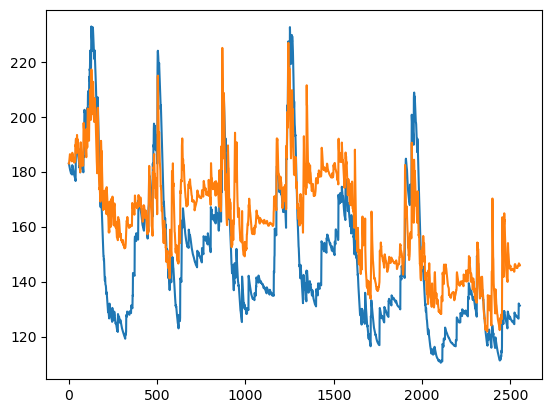

In [64]:
# test
ixy = 0

loss_fn(
    theta,
    x_forcing_nt[ixy],
    x_forcing_nyrs[ixy],
    x_maps[ixy],
    ys[ixy]
)

Array(17.38499, dtype=float32)

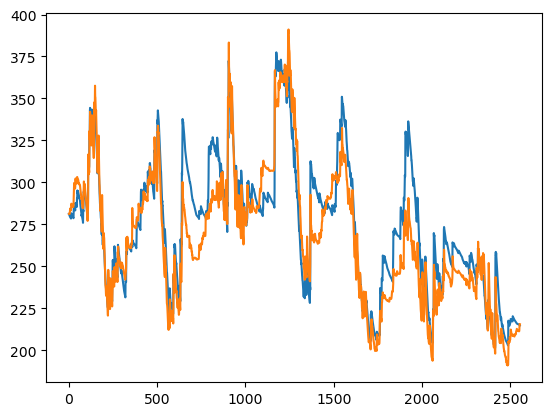

In [63]:
# test
ixy = 5001

loss_fn(
    theta,
    x_forcing_nt[ixy],
    x_forcing_nyrs[ixy],
    x_maps[ixy],
    ys[ixy]
)

In [60]:
def loss_fn(theta,
            x_forcing_nt,
            x_forcing_nyrs,
            x_maps,
            ys
           ):

    # Read inputs
    tas, prcp = x_forcing_nt
    lai = x_forcing_nyrs
    awCap, wiltingp, \
    Ws_init, Wi_init, Sp_init, \
    clayfrac, sandfrac, siltfrac, \
    lats, elev_std, \
    corn, cotton, rice, sorghum, soybeans, wheat \
    = x_maps
    
    
    # Define all params
    awCap_scalar, wiltingp_scalar, \
    alpha_claycoef, alpha_sandcoef, alpha_siltcoef, \
    betaHBV_claycoef, betaHBV_sandcoef, betaHBV_siltcoef, betaHBV_elevcoef, \
    GS_start_corn, GS_length_corn, L_ini_corn, L_dev_corn, L_mid_corn, Kc_ini_corn, Kc_mid_corn, Kc_end_corn, K_min_corn, K_max_corn, \
    GS_start_cotton, GS_length_cotton, L_ini_cotton, L_dev_cotton, L_mid_cotton, Kc_ini_cotton, Kc_mid_cotton, Kc_end_cotton, K_min_cotton, K_max_cotton, \
    GS_start_rice, GS_length_rice, L_ini_rice, L_dev_rice, L_mid_rice, Kc_ini_rice, Kc_mid_rice, Kc_end_rice, K_min_rice, K_max_rice,  \
    GS_start_sorghum, GS_length_sorghum, L_ini_sorghum, L_dev_sorghum, L_mid_sorghum, Kc_ini_sorghum, Kc_mid_sorghum, Kc_end_sorghum, K_min_sorghum, K_max_sorghum, \
    GS_start_soybeans, GS_length_soybeans, L_ini_soybeans, L_dev_soybeans, L_mid_soybeans, Kc_ini_soybeans, Kc_mid_soybeans, Kc_end_soybeans, K_min_soybeans, K_max_soybeans, \
    GS_start_wheat, GS_length_wheat, L_ini_wheat, L_dev_wheat, L_mid_wheat, Kc_ini_wheat, Kc_mid_wheat, Kc_end_wheat, K_min_wheat, K_max_wheat \
    = jnp.exp(theta)

    # Construct Kpet as weighted average
    Kpet_corn = construct_Kpet_vec(GS_start_corn, GS_length_corn, L_ini_corn, L_dev_corn, L_mid_corn, 1. - (L_ini_corn + L_dev_corn + L_mid_corn), Kc_ini_corn, Kc_mid_corn, Kc_end_corn, K_min_corn, K_max_corn, lai)
    Kpet_cotton = construct_Kpet_vec(GS_start_cotton, GS_length_cotton, L_ini_cotton, L_dev_cotton, L_mid_cotton, 1. - (L_ini_cotton + L_dev_cotton + L_mid_cotton), Kc_ini_cotton, Kc_mid_cotton, Kc_end_cotton, K_min_cotton, K_max_cotton, lai)
    Kpet_rice = construct_Kpet_vec(GS_start_rice, GS_length_rice, L_ini_rice, L_dev_rice, L_mid_rice, 1. - (L_ini_rice + L_dev_rice + L_mid_rice), Kc_ini_rice, Kc_mid_rice, Kc_end_rice, K_min_rice, K_max_rice, lai)
    Kpet_sorghum = construct_Kpet_vec(GS_start_sorghum, GS_length_sorghum, L_ini_sorghum, L_dev_sorghum, L_mid_sorghum, 1. - (L_ini_sorghum + L_dev_sorghum + L_mid_sorghum), Kc_ini_sorghum, Kc_mid_sorghum, Kc_end_sorghum, K_min_sorghum, K_max_sorghum, lai)
    Kpet_soybeans = construct_Kpet_vec(GS_start_soybeans, GS_length_soybeans, L_ini_soybeans, L_dev_soybeans, L_mid_soybeans, 1. - (L_ini_soybeans + L_dev_soybeans + L_mid_soybeans), Kc_ini_soybeans, Kc_mid_soybeans, Kc_end_soybeans, K_min_soybeans, K_max_soybeans, lai)
    Kpet_wheat = construct_Kpet_vec(GS_start_wheat, GS_length_wheat, L_ini_wheat, L_dev_wheat, L_mid_wheat, 1. - (L_ini_wheat + L_dev_wheat + L_mid_wheat), Kc_ini_wheat, Kc_mid_wheat, Kc_end_wheat, K_min_wheat, K_max_wheat, lai)

    other = 1. - (corn + cotton + rice + sorghum + soybeans + wheat)
    weights = jnp.array([corn, cotton, rice, sorghum, soybeans, wheat, other])
    Kpets = jnp.array([Kpet_corn, Kpet_cotton, Kpet_rice, Kpet_sorghum, Kpet_soybeans, Kpet_wheat, jnp.ones(365)])
    Kpet = jnp.average(Kpets, weights = weights, axis=0)
    
    # params that WBM sees
    awCap_scaled = awCap * awCap_scalar
    wiltingp_scaled = wiltingp * wiltingp_scalar
    alpha = 1.0 + (alpha_claycoef * clayfrac) + (alpha_sandcoef * sandfrac) + (alpha_siltcoef * siltfrac)
    betaHBV = 1.0 + (betaHBV_claycoef * clayfrac) + (betaHBV_sandcoef * sandfrac) + (betaHBV_siltcoef * siltfrac) + (betaHBV_elevcoef * elev_std)
    
    params = (Ts, Tm, wiltingp_scaled, awCap_scaled, alpha, betaHBV)
    
    # Make prediction
    prediction = wbm_jax(
        tas,
        prcp, 
        Kpet,
        Ws_init,
        Wi_init,
        Sp_init,
        lai,
        lats,
        params
    )
    # Return RMSE 
    plt.plot(prediction)
    plt.plot(ys)
    return jnp.sqrt(jnp.mean((prediction-ys)**2))